## Let's look at boundary and label monotonicity in Hierarchical labels: SALAMI.


In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Let's get the directory of jams files:
import os, jams, mir_eval, bnl, json, tqdm
import numpy as np
import xarray as xr
from tqdm import tqdm


In [4]:
def get_ref_hiers(tid, salami_jams_dir='/Users/tomxi/data/salami-jams'):
    jams_path = os.path.join(salami_jams_dir, tid + '.jams')
    jam = jams.load(jams_path)
    duration = jam.file_metadata.duration
    upper = jam.search(namespace='segment_salami_upper')
    lower = jam.search(namespace='segment_salami_lower')
    anno_h_list = []
    for anno_id in range(len(upper)):
        upper[anno_id].duration = duration
        lower[anno_id].duration = duration
        anno_h = bnl.multi2H(bnl.fmt.openseg2multi([upper[anno_id], lower[anno_id]]))
        anno_h_list.append(anno_h)
    return anno_h_list

def get_adobe_hiers(tid, result_dir='/Users/tomxi/data/ISMIR21-Segmentations/SALAMI/def_mu_0.1_gamma_0.1/') -> jams.Annotation:
    filename = f'{tid}.mp3.msdclasscsnmagic.json'

    with open(os.path.join(result_dir, filename), 'rb') as f:
        adobe_hier = json.load(f)

    anno = bnl.fmt.hier2multi(adobe_hier)
    anno.sandbox.update(mu=0.1, gamma=0.1)
    return bnl.multi2H(anno)



## Experiment: How monoboundary forcing change T measure on Adobe outputs against all annotations scatter plots

In [5]:
from pqdm.processes import pqdm
from meet_mats import save_tmeasure
import bnl, os
results = pqdm(bnl.utils.get_salami_tids(), save_tmeasure, n_jobs=os.cpu_count())

QUEUEING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1359 [00:00<?, ?it/s]

In [8]:
len(results)

1359

In [14]:
results = save_tmeasure(10)
print(results)

{'orig_r': (0.25584578916195255, 0.35163441795203737, 0.29618803741719807), 'orig_f': (0.5513463387304033, 0.38203909737373204, 0.4513373563402699), 'tmeasure1_r': (0.2275783549160091, 0.3461351133241009, 0.27460697379339655), 'tmeasure0_r': (0.25584578916195255, 0.35163441795203737, 0.29618803741719807), 'tmeasure1_f': (0.5522161664460671, 0.3742096293437834, 0.44611151352331907), 'tmeasure0_f': (0.5513463387304033, 0.38203909737373204, 0.4513373563402699)}


In [ ]:
# I want to iterate through all the tracks and compute T measure, before and after forcing mono B
full_results = {}
reduced_results = {}

bnl.utils.suppress_mir_eval_warnings()
for tid in tqdm(bnl.utils.get_salami_tids()):
    for anno_id, ref_h in enumerate(get_ref_hiers(tid)):
        est_h = get_adobe_hiers(tid)
        est_h_mono0 = est_h.force_mono_B(min_seg_dur=0)
        est_h_mono1 = est_h.force_mono_B(min_seg_dur=0.5)
        t_measure_raw = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h.itvls), transitive=True)
        t_measure_mono0 = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h_mono0.itvls), transitive=True)
        t_measure_mono1 = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h_mono1.itvls), transitive=True)
        full_results[f'{tid}_{anno_id}'] = (t_measure_raw, t_measure_mono0, t_measure_mono1)

        reduced_t_measure_raw = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h.itvls), transitive=False)
        reduced_t_measure_mono0 = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h_mono0.itvls), transitive=False)
        reduced_t_measure_mono1 = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h_mono1.itvls), transitive=False)
        reduced_results[f'{tid}_{anno_id}'] = (reduced_t_measure_raw, reduced_t_measure_mono0, reduced_t_measure_mono1)
    break

print(full_results)
print(reduced_results)

  0%|          | 0/1359 [00:48<?, ?it/s]

{'10_0': ((0.5675121771365692, 0.3734003277828668, 0.45043345019993686), (0.5424223344013609, 0.38478124104399897, 0.4502008933705588), (0.5472163186656428, 0.38313669075369083, 0.45070773639100054)), '10_1': ((0.5423012828087669, 0.3387499618835985, 0.4170121544860652), (0.5513463387304033, 0.38203909737373204, 0.4513373563402699), (0.553326171354915, 0.3786918270755386, 0.4496481809406624))}
{'10_0': ((0.2585893354831497, 0.39316533636992934, 0.3119835344726996), (0.33780568700415015, 0.40230594248139306, 0.3672452367225874), (0.4498514425317346, 0.4006104949195406, 0.42380546641038214)), '10_1': ((0.19721654525525684, 0.3187909264178669, 0.24368191787223348), (0.25584578916195255, 0.35163441795203737, 0.29618803741719807), (0.2141649772099362, 0.34798920705565645, 0.26514825535183684))}


In [ ]:
## Experiment: CHange the depth of the hierarchy and how that affects the T measure?

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

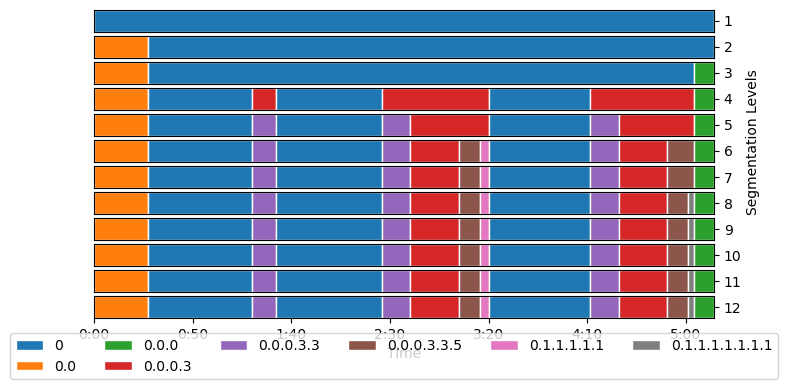

In [71]:
h = get_adobe_hiers(tid).force_mono_L(min_seg_dur=2)
h.plot()

(<Figure size 800x400 with 7 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

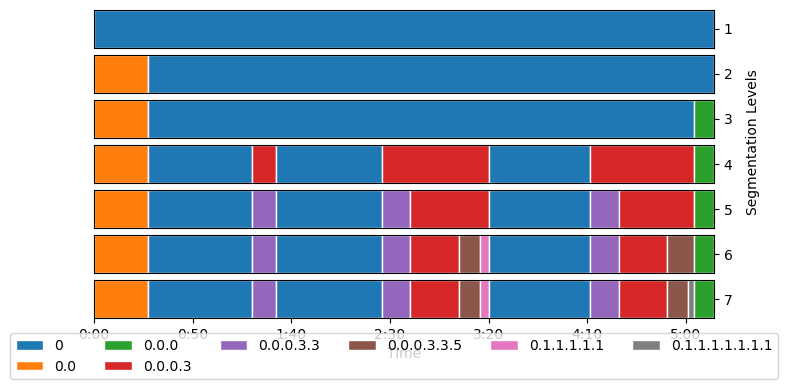

In [73]:
h.prune_identical_levels().plot()

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

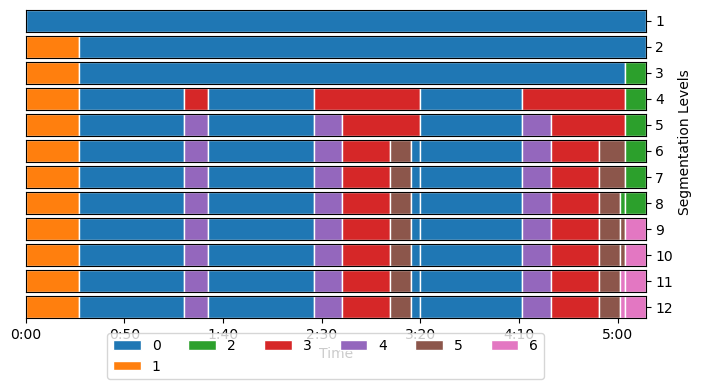

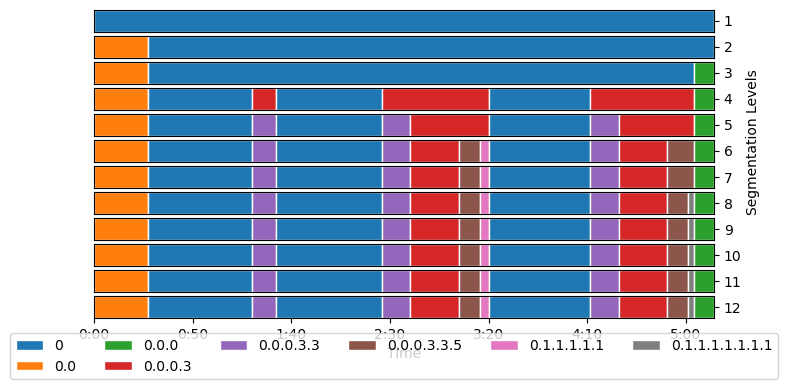

In [56]:
get_adobe_hiers(tid).force_mono_B(min_seg_dur=2).plot(relabel=False)
get_adobe_hiers(tid).force_mono_L(min_seg_dur=2).plot(relabel=True)

In [ ]:
# Let's do it on all files
from tqdm import tqdm

for tid in tqdm(bnl.utils.get_salami_tids()):
    hiers = get_ref_hiers(tid)
    for anno_id, h in enumerate(hiers):
        if not h.has_mono_B():
            print(f'{tid} annotator {anno_id} has non-monotonic boundaries!')

## Everything has monotonic boundaries!

100%|██████████| 1359/1359 [00:13<00:00, 101.53it/s]
